<a href="https://colab.research.google.com/github/IssyMiddleton/CSC8635/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive
%cd /gdrive/MyDrive/CSC8635/
## Check that the data_subjects_info.csv is in the current folder location
#@title
## set up the libraries that are needed to run the analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

Mounted at /gdrive
/gdrive
/gdrive/MyDrive/CSC8635


In [ ]:
#@title
## import the file with the data subjects details
df1 = pd.read_csv('data_subjects_info.csv', delimiter=',')
df1.dataframeName = 'data_subjects_info.csv'
nRow, nCol = df1.shape
print(f'The dimensions of the data_subjects_info.csv dataset are {nRow} rows and {nCol} columns.')

The dimensions of the data_subjects_info.csv dataset are 24 rows and 5 columns.


The first five records of the dataset look like this:

In [ ]:
#@title
df1.head(5)

,code,weight,height,age,gender
0,1,102,188,46,1
1,2,72,180,28,1
2,3,48,161,28,0
3,4,90,176,31,1
4,5,48,164,23,0


The Histograms for the data show the variation in weight, height, age and gender of the participants in the trail. The majority are under 80kg, under 165cm and under 35 years of age. Fourteen males and ten females participated.

In [ ]:
#@title
Reduceddf1 = df1[["weight","height","age","gender"]]

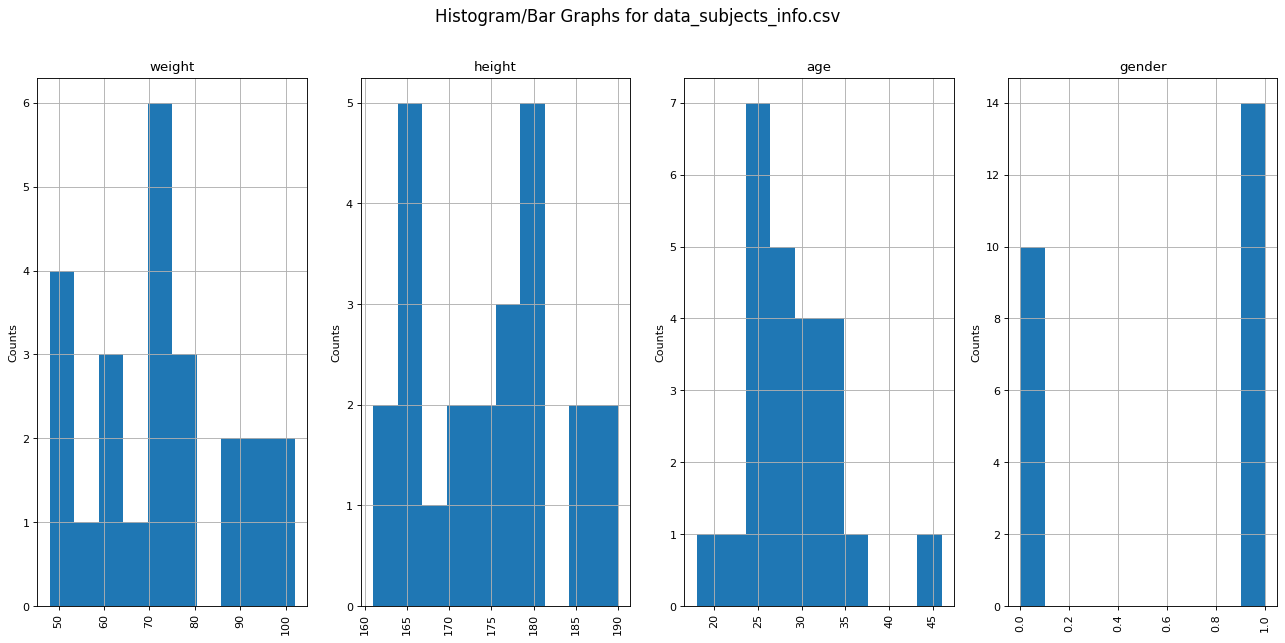

In [ ]:
#@title
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (5 * nGraphPerRow, 5 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]}')
    #plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.suptitle(f'Histogram/Bar Graphs for data_subjects_info.csv', fontsize=15)
    plt.show()

plotPerColumnDistribution(Reduceddf1, 10, 4)

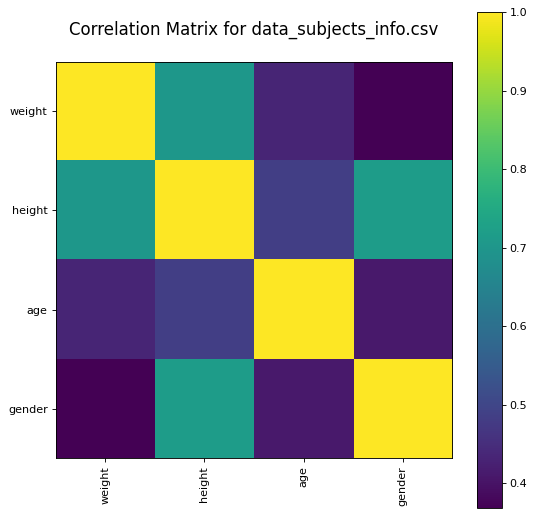

In [ ]:
#@title
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for data_subjects_info.csv', fontsize=15)
    plt.show()

plotCorrelationMatrix(Reduceddf1, 8)

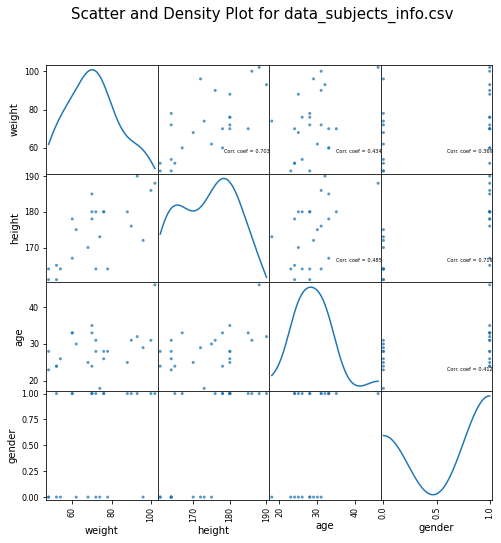

In [ ]:
#@title
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle(f'Scatter and Density Plot for data_subjects_info.csv', fontsize=15)
    #plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterMatrix(Reduceddf1, 8, 5)

In [ ]:
#@title
#set up for machine learning
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf

import os
#print(os.listdir("A_DeviceMotion_data/A_DeviceMotion_data"))

# Data Folders:
Folders = glob('A_DeviceMotion_data/A_DeviceMotion_data/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 samples frames , each one will be a different experiment
Segment_Size = 400

# Activity types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
  Csv = glob(j + '/*' )
  for i in Csv:
    df = pd.read_csv(i)
    df['Activity'] = activity_codes[j[40:43]]
    df['Sub_Num'] = i[len(j)+5:-4]
    df['Exp_num'] = 1
    ExpNum = np.zeros((df.shape[0])) 
    for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
      ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
    df['Exp_num'] = ExpNum
    #Df_all = pd.concat([Df_all,df])
    Df_all_list.append(df)
    Exp += 1        
Df_all = pd.concat(Df_all_list,axis=0)  
print(f'The data has been loaded.')
print(f'The dimensions of the complete dataset are {Df_all.shape}.')
print(f'The 16 column headers are {Df_all.columns}.')
#check unique values for the participants
#np.unique(Df_all['Sub_Num'])

The data has been loaded.
The dimensions of the complete dataset are (1412865, 16).
The 16 column headers are Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object').


In [ ]:
df1 = pd.read_csv('data_subjects_info.csv', delimiter=',')
df1.dataframeName = 'data_subjects_info.csv'

In [ ]:
import numpy as np
import pandas as pd
##_____________________________

def get_ds_infos():
    ## 0:Code, 1:Weight, 2:Height, 3:Age, 4:Gender
    dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
    dss = dss[1:]
    print("----> Data subjects information is imported.")
    return dss
##____________

def creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes):
    dataset_columns = num_features+num_act_labels+num_gen_labels
    ds_list = get_ds_infos()
    train_data = np.zeros((0,dataset_columns))
    test_data = np.zeros((0,dataset_columns))
    for i, sub_id in enumerate(ds_list[:,0]):
        for j, act in enumerate(label_codes):
            for trial in trial_codes[act]:
                fname = 'A_DeviceMotion_data/A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
                raw_data = pd.read_csv(fname)
                raw_data = raw_data.drop(['Unnamed: 0'], axis=1)
                unlabel_data = raw_data.values
                label_data = np.zeros((len(unlabel_data), dataset_columns))
                label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
                label_data[:,label_codes[act]] = 1
                label_data[:,-(num_gen_labels)] = int(ds_list[i,4])
                ## We consider long trials as training dataset and short trials as test dataset
                if trial > 10:
                    test_data = np.append(test_data, label_data, axis = 0)
                else:    
                    train_data = np.append(train_data, label_data, axis = 0)
    return train_data , test_data
#________________________________


In [ ]:
print("--> Start...")
## Here we set parameter to build labeld time-series from dataset of "(A)DeviceMotion_data"
num_features = 12 # attitude(roll, pitch, yaw); gravity(x, y, z); rotationRate(x, y, z); userAcceleration(x,y,z)
num_act_labels = 6 # dws, ups, wlk, jog, sit, std
num_gen_labels = 1 # 0/1(female/male)
label_codes = {"dws":num_features, "ups":num_features+1, "wlk":num_features+2, "jog":num_features+3, "sit":num_features+4, "std":num_features+5}
trial_codes = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}    
## Calling 'creat_time_series()' to build time-series

--> Start...


In [ ]:
print("--> Building Training and Test Datasets...")
train_ts, test_ts = creat_time_series(num_features, num_act_labels, num_gen_labels, label_codes, trial_codes)

--> Building Training and Test Datasets...
----> Data subjects information is imported.


In [ ]:
print("--> Shape of Training Time-Series:", train_ts.shape)
print("--> Shape of Test Time-Series:", test_ts.shape)

--> Shape of Training Time-Series: (1081446, 19)
--> Shape of Test Time-Series: (331419, 19)


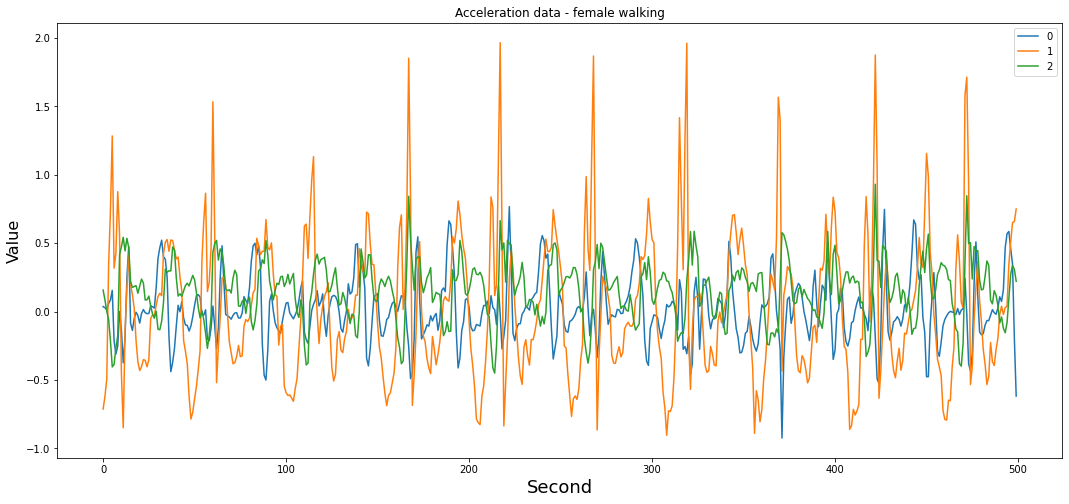

In [ ]:
from pandas import Series
import matplotlib.pylab as plt
import matplotlib.pyplot as pyplt
## For Example: Acceleration data
## female
data = train_ts[train_ts[:,-1]==0]
## walking
data = data[data[:,-5]==1]
data = pd.DataFrame(data[10000:10500,9:12])
data.plot()
plt.xlabel('Second', fontsize=18)
plt.ylabel('Value', fontsize=16)
plt.title('Acceleration data - female walking')
lgnd=plt.legend()
#lgnd.get_texts()[0].set_text('x')
#lgnd.get_texts()[1].set_text('y')
#lgnd.get_texts()[2].set_text('z')
fig = pyplt.gcf()
fig.set_size_inches(18, 8)
plt.show()

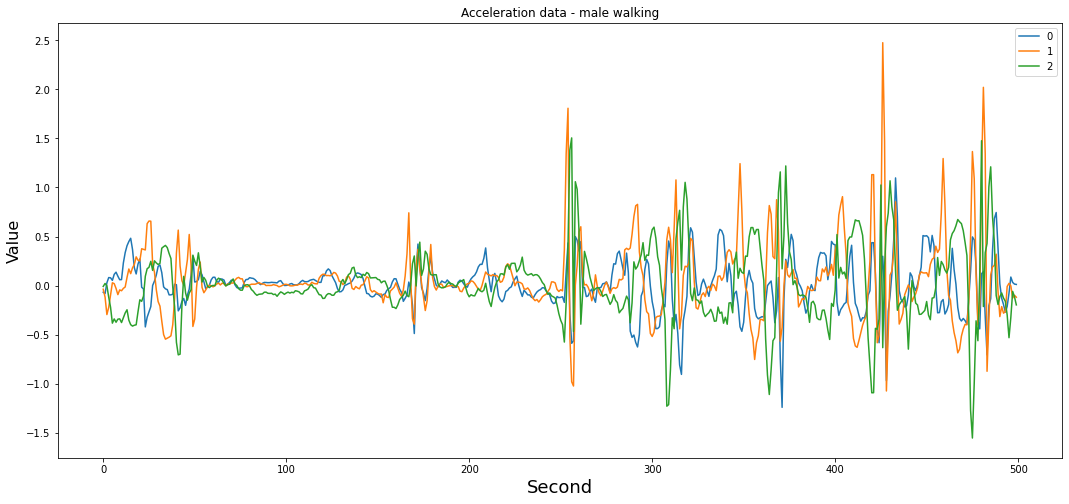

In [ ]:
## For Example: Acceleration data
## male
data = train_ts[train_ts[:,-1]==1]
## walking
data = data[data[:,-5]==1]
data = pd.DataFrame(data[10000:10500,9:12])
data.plot()
plt.xlabel('Second', fontsize=18)
plt.ylabel('Value', fontsize=16)
plt.title('Acceleration data - male walking')
lgnd=plt.legend()
#lgnd.get_texts()[0].set_text('x')
#lgnd.get_texts()[1].set_text('y')
#lgnd.get_texts()[2].set_text('z')
fig = pyplt.gcf()
fig.set_size_inches(18, 8)
plt.show()


In [ ]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf

import os
#print(os.listdir("A_DeviceMotion_data/A_DeviceMotion_data"))

# Data Folders:
Folders = glob('A_DeviceMotion_data/A_DeviceMotion_data/*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 sampels frames , each one will be a different Expirament
Segment_Size = 400

# Activety types dict:
activity_codes = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
activity_types = list(activity_codes.keys())

# Load All data:
for j  in Folders:
    Csv = glob(j + '/*' )


    for i in Csv:
        df = pd.read_csv(i)
        # Add Activety label, Subject name and Experiment number
        df['Activity'] = activity_codes[j[40:43]]
        df['Sub_Num'] = i[len(j)+5:-4]
        df['Exp_num'] = 1
        ExpNum = np.zeros((df.shape[0])) 
        for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
            ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
        df['Exp_num'] = ExpNum
        #Df_all = pd.concat([Df_all,df])
        Df_all_list.append(df)
        Exp += 1        

Df_all = pd.concat(Df_all_list,axis=0)  
print(Df_all.shape)
print(Df_all.columns)

(1412865, 16)
Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object')


In [ ]:
Df_all.tail(15)

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,Activity,Sub_Num,Exp_num
2828,2828,-0.374310,-1.151761,-0.762672,-0.148767,0.913482,-0.378707,2.781470,-1.479057,2.559349,-2.217627,0.454468,0.918532,2,24,0.0
2829,2829,-0.268354,-1.113876,-0.600857,-0.116978,0.897416,-0.425395,2.520643,-2.144695,2.479332,-0.048229,-0.023163,1.097484,2,24,0.0
2830,2830,-0.199763,-1.082359,-0.479858,-0.093116,0.883067,-0.459914,2.019184,-1.383730,2.292188,0.372810,-0.313533,1.378311,2,24,0.0
2831,2831,-0.111714,-1.056933,-0.388655,-0.054798,0.870852,-0.488481,1.261787,1.009070,1.570259,-0.183102,-0.474704,0.774980,2,24,0.0
2832,2832,-0.078922,-1.050127,-0.355456,-0.039220,0.867486,-0.495912,-0.067090,-0.371460,0.309722,-0.710902,-0.974573,0.945894,2,24,0.0
2833,2833,-0.106995,-1.063196,-0.377424,-0.051909,0.873913,-0.483302,-0.977460,-0.214327,-0.898588,-1.047136,-1.449414,0.888255,2,24,0.0
2834,2834,-0.161019,-1.087339,-0.454846,-0.074526,0.885393,-0.458830,-1.931169,1.578623,-2.223597,-1.061796,-1.922915,1.063444,2,24,0.0
2835,2835,-0.262435,-1.133855,-0.611622,-0.109784,0.906050,-0.408682,-3.284828,1.064583,-3.035697,0.360456,-1.016875,0.770574,2,24,0.0
2836,2836,-0.461440,-1.171292,-0.804846,-0.173181,0.921254,-0.348281,-3.122022,-1.883585,-3.039327,0.857629,-0.125050,0.815750,2,24,0.0
2837,2837,-0.719296,-1.188276,-1.052187,-0.245924,0.927727,-0.280792,-3.211565,-1.387202,-3.750956,0.163863,0.089577,-0.520828,2,24,0.0


In [ ]:
#  Calculate features
df_sum = Df_all.groupby('Exp_num', axis=0).mean().reset_index()
df_sum.columns = df_sum.columns.str.replace('.','_sum_')

df_sum_SS = np.power(Df_all.astype(float),2).groupby('Exp_num', axis=0).median().reset_index() 
df_sum_SS.columns = df_sum_SS.columns.str.replace('.','_sumSS_')

df_max = Df_all.groupby('Exp_num', axis=0).max().reset_index()
df_max.columns = df_max.columns.str.replace('.','_max_')

df_min = Df_all.groupby('Exp_num', axis=0).min().reset_index()
df_min.columns = df_min.columns.str.replace('.','_min_')

df_skew = Df_all.groupby('Exp_num', axis=0).skew().reset_index()
df_skew.columns = df_skew.columns.str.replace('.','_skew_')

df_std = Df_all.groupby('Exp_num', axis=0).std().reset_index()
df_std.columns = df_std.columns.str.replace('.','_std_')

Df_Features = pd.concat([ df_max , df_sum[df_sum.columns[2:-2]], 
                         df_min[df_min.columns[2:-2]], df_sum_SS[df_sum_SS.columns[2:-2]], 
                         df_std[df_std.columns[2:-2]], df_skew[df_skew.columns[2:-2]]], axis=1)

X = Df_Features.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Y = Df_Features['Activity']
B = Df_Features['Sub_Num']
print('Shape of X:', X.shape)
print('Shape of Y:', Y.shape)

Shape of X: (3359, 70)
Shape of Y: (3359,)


In [ ]:
Df_all

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,Activity,Sub_Num,Exp_num
0,0,0.838472,-0.901646,0.189667,0.461284,0.784349,-0.414745,0.127156,2.833157,-0.227154,-0.097468,-0.011766,0.079388,5,1,0.0
1,1,0.901238,-0.900320,0.177763,0.487205,0.783526,-0.385640,0.076840,4.165144,-0.281555,0.375618,0.492231,0.449682,5,1,0.0
2,2,0.993089,-0.914963,0.185652,0.510856,0.792540,-0.333025,-0.794123,3.879236,-0.488098,0.061608,0.260805,0.489626,5,1,0.0
3,3,1.029530,-0.921919,0.171090,0.517913,0.796763,-0.311345,0.701853,1.728788,-0.538987,-0.107970,0.133718,-0.024181,5,1,0.0
4,4,1.052038,-0.927877,0.156188,0.520657,0.800349,-0.297251,-0.233936,2.031018,-0.449770,-0.025372,-0.095515,0.276041,5,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2838,2838,-1.017175,-1.162354,-1.310722,-0.337852,0.917741,-0.208826,-2.999562,-4.098313,-4.736243,-0.895730,1.181624,-0.150626,2,24,0.0
2839,2839,-1.292318,-1.078857,-1.562349,-0.454140,0.881418,-0.129842,-3.015364,0.439013,-6.663899,-2.954521,4.183477,0.853444,2,24,0.0
2840,2840,-1.403760,-0.951444,-1.709745,-0.572428,0.814255,-0.096516,-2.786093,-0.210998,-6.814220,-1.778753,3.831970,-0.317043,2,24,0.0
2841,2841,-1.504000,-0.843886,-1.828078,-0.663082,0.747231,-0.044358,-2.645476,-0.743427,-5.391820,-0.212925,1.475883,-0.199691,2,24,0.0


Some participants completed more activities, and for longer, than others.

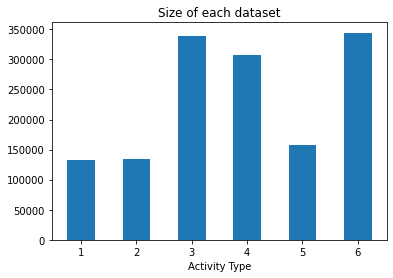

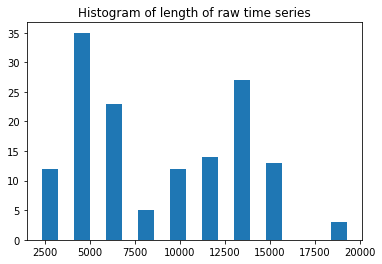

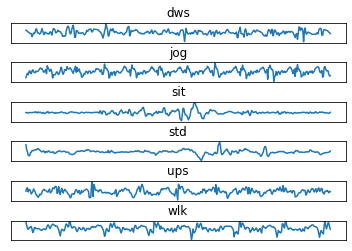

In [ ]:
#@title
### Missing values
##checks = pd.isna(Df_all).sum()
##print(checks)
### class balance
class_counts = list()

for act in activity_types[:1]:
    class_counts.append(Df_all[Df_all['Activity']==activity_codes[act]].count())
plt.figure(1)
plt.title('Size of each dataset')
plt.xlabel('Activity Type')
plt.hist(Df_all['Activity'],bins=range(1,8),rwidth=0.5,align='left')

### Length of time series
series_length = list()
for act in activity_types:
    for sub in range(1,25):
        sub = str(sub)
        series_length.append(Df_all[(Df_all['Sub_Num']==sub) & (Df_all['Activity']==activity_codes[act])].shape[0])
plt.figure(2)
plt.title('Histogram of length of raw time series')
plt.hist(series_length,rwidth=0.5,align='left')

### show the first few records of motion type
plt.figure(3)
colors = ['r','g','b','c','m','y','k']
for act in activity_types:
    plt.subplot('61'+str(activity_codes[act]))
    plt.subplots_adjust(hspace=1.0)
    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    plt.title(act)
    plt.plot(df['userAcceleration.z'][:400])
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels

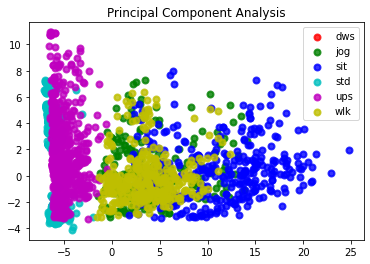

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#### dimension reduction
### use pca to reduce the dimension to 2D directly.
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

plt.figure(1)
colors = ['r','g','b','c','m','y','k']
lw = 2

for color, i, target_name in zip(colors, range(6), activity_types):
    plt.scatter(X_r[Y == i, 0], X_r[Y == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('Principal Component Analysis')

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

###Hierachical clustering with dynamic time wrapping

Using the methods provided by library "dtaidistance.", 400 datapoints of each motion type are segmented and similiarity between each segment is calculated by dynamic time wrapping.


In [ ]:
series_list = list()
labels_list = list()
for act in activity_types:

    df = Df_all[(Df_all['Sub_Num']=='1') & (Df_all['Activity']==activity_codes[act])]
    series_list.append(df['userAcceleration.z'][:400])
    labels_list.extend([act])

print(labels_list)

['dws', 'jog', 'sit', 'std', 'ups', 'wlk']


In [ ]:
pip install dtaidistance

In [ ]:
import matplotlib.pyplot as plt
from dtaidistance import dtw, clustering
import numpy as np

series = np.array(series_list)
ds = dtw.distance_matrix_fast(series)

model = clustering.LinkageTree(dtw.distance_matrix_fast, {})
model.fit(series)
model.plot(show_ts_label=labels_list,
           show_tr_label=True)

The compiled dtaidistance C library is not available.
See the documentation for alternative installation options.


Exception: ignored

Based on hierachical clustering, 'dws', 'ups', 'wlk' are similar to each other, 'sit' and 'std' are similair, and 'jog' is distinctive from the other five.

Train multi-layer perceptron classifier

In [ ]:
import itertools

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from keras.datasets import mnist
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense
from keras.models import Model
from keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import keras

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.utils import np_utils

from sklearn.neighbors import KNeighborsClassifier


In [ ]:
#### Construct neural architecture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(7, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

Check Y is activity

In [ ]:
# One-hot encoding
Y = to_categorical(Y)
print(Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

(3359, 7)


ValueError: ignored

In [ ]:
#### Check model performance
### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

32/32 [==============================] - 0s 1ms/step - loss: 0.0085 - categorical_accuracy: 0.9921
keras test accuracy score: 0.9920634627342224


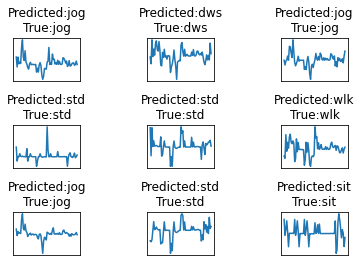

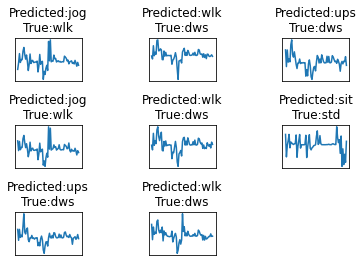

In [ ]:
# One-hot decoding
y_pred = np.argmax(model.predict(X_test),axis=1)
y_test = np.argmax(Y_test,axis=1)
#print(y_pred,y_test)

correct = np.nonzero(y_pred==y_test)[0]
incorrect = np.nonzero(y_pred!=y_test)[0]
#print(correct)

### Check the correctly-predicted samples
plt.figure(1)
for i, cor in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(X_test.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1], 
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()
### Check the incorrectly-predicted samples
plt.figure(2)
for i, cor in enumerate(incorrect[:9]):
    plt.subplot(3,3,i+1)
    plt.subplots_adjust(hspace=1.0,wspace=1.0)
    plt.plot(X_test.iloc[cor,:])
    plt.title("Predicted:{}\nTrue:{}".format(activity_types[y_pred[cor]-1], 
                                              activity_types[y_test[cor]-1]))
    plt.xticks([]) # turn off x labels
    plt.yticks([])  # turn off y labels
    #plt.tight_layout()
plt.show()

'ups' has the highest misclassification rate, and is clasified as 'dws' and 'wlk'

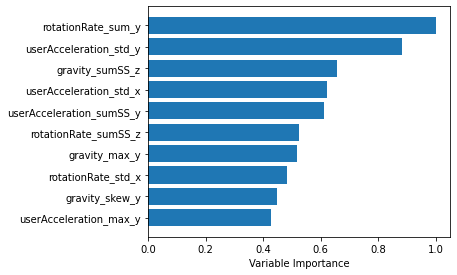

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

clf1 = RandomForestClassifier(n_estimators=100, max_depth=None,
     min_samples_split=2, random_state=0)
clf1.fit(X_train, Y_train)
featureImportance = clf1.feature_importances_

# normalize by max importance
featureImportance = featureImportance / featureImportance.max()
feature_names = X.columns
idxSorted = np.argsort(featureImportance)[-10:]
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos, featureImportance[idxSorted], align='center')
plt.yticks(barPos, feature_names[idxSorted])
plt.xlabel('Variable Importance')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()


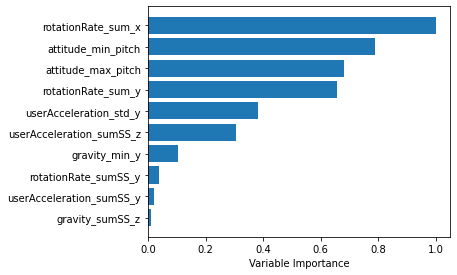

In [ ]:
# Need to one-hot decode before feeding into GBM
y_train = np.argmax(Y_train,axis=1)
clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=1, random_state=0)
clf2.fit(X_train, y_train)
featureImportance = clf2.feature_importances_


# normalize by max importance
featureImportance = featureImportance / featureImportance.max()
feature_names = X.columns
idxSorted = np.argsort(featureImportance)[-10:]
barPos = np.arange(idxSorted.shape[0]) + .5
plt.barh(barPos, featureImportance[idxSorted], align='center')
plt.yticks(barPos, feature_names[idxSorted])
plt.xlabel('Variable Importance')
plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.1)
plt.show()

In [ ]:
# Let target label become subjects
Y1 = Df_Features['Sub_Num']


In [ ]:
#### Construct neural Architeture for baseline model
input_dim = X.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(25, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])

In [ ]:
# One-hot encoding

y1 = to_categorical(Y1)
print(Y1.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, y1, test_size=0.3, random_state=0)

history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

(3359,)
32/32 [==============================] - 0s 1ms/step - loss: 0.0622 - categorical_accuracy: 0.8145
keras test accuracy score: 0.8144841194152832


In [ ]:
for i in range(1,7):
    df = Df_Features[Df_Features['Activity']==i]
    x = df.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
    y = df['Sub_Num']
    y = to_categorical(y)
    
    #### Construct neural Architeture
    input_dim = x.shape[1]
    input_img = Input(shape=(input_dim,))
    d = Dense(50, activation='relu')(input_img)
    d = Dense(20, activation='relu')(d)
    output = Dense(25, activation='softmax', kernel_regularizer=l2(0.01))(d)
    model = Model(input_img,output)
    model.compile(optimizer='adam', loss='binary_crossentropy',
                     metrics=['categorical_accuracy'])
    
    X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

    history = model.fit(X_train, Y_train,
                    epochs=1000,
                    batch_size=100,
                    shuffle=True,
                    verbose=0,
                    validation_data=[X_test,Y_test])

    ### Overall test accuracy
    score = model.evaluate(X_test, Y_test)
    print('Activity type:', activity_types[i-1])
    print('keras test accuracy score:', score[1])

3/3 [==============================] - 0s 6ms/step - loss: 0.0694 - categorical_accuracy: 0.7865
Activity type: dws
keras test accuracy score: 0.7865168452262878
3/3 [==============================] - 0s 6ms/step - loss: 0.0370 - categorical_accuracy: 0.9362
Activity type: jog
keras test accuracy score: 0.936170220375061
8/8 [==============================] - 0s 3ms/step - loss: 0.0335 - categorical_accuracy: 0.9150
Activity type: sit
keras test accuracy score: 0.9149797558784485
7/7 [==============================] - 0s 3ms/step - loss: 0.0894 - categorical_accuracy: 0.6384
Activity type: std
keras test accuracy score: 0.6383928656578064
4/4 [==============================] - 0s 3ms/step - loss: 0.0402 - categorical_accuracy: 0.8981
Activity type: ups
keras test accuracy score: 0.8981481194496155
8/8 [==============================] - 0s 2ms/step - loss: 0.0201 - categorical_accuracy: 0.9558
Activity type: wlk
keras test accuracy score: 0.9558233022689819


Check Overfitting

Gender: 1 for male and 0 for female

In [ ]:
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':1,
    '22':1,
    '23':0,
    '24':0

}

In [ ]:
# Create gender labels
Y2 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
y2 = to_categorical(Y2)

X_train, X_test, Y_train, Y_test = train_test_split(X, y2, test_size=0.3, random_state=0)
print('The number of training samples:',X_train.shape[0])
print('The number of test samples:',X_test.shape[0])


#### Construct neural Architeture for baseline model
input_dim = x.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

The number of training samples: 2351
The number of test samples: 1008
32/32 [==============================] - 0s 2ms/step - loss: 0.6275 - categorical_accuracy: 0.9018
keras test accuracy score: 0.9017857313156128


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y2, test_size=0.3, random_state=0)

LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)

clf = KNeighborsClassifier(5)
KNN = clf.fit(X_train, Y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print('Model performance - gender identification')
print('LinearSVM accuracy:',accuracy_score(Y_test, SVM_linear.predict(X_test)))
print('LinearSVM mean_f1:',f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'))
print('rbf_SVM accuracy:',accuracy_score(Y_test, SVM_rbf.predict(X_test)))
print('rbf_SVM mean_f1:',f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'))
print('Logistic_regression (L1) accuracy:',accuracy_score(Y_test, LR_L1.predict(X_test)))
print('Logistic_regression (L1) mean_f1:',f1_score(Y_test,LR_L1.predict(X_test),average ='macro'))
print('Logistic_regression (L2) accuracy:',accuracy_score(Y_test, LR_L2.predict(X_test)))
print('Logistic_regression (L2) mean_f1:',f1_score(Y_test,LR_L2.predict(X_test),average ='macro'))
print('Decision tree accuracy:',accuracy_score(Y_test, DT.predict(X_test)))
print('Decision tree mean_f1:',f1_score(Y_test,DT.predict(X_test),average ='macro'))
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
print('Random Forest mean_f1:',f1_score(Y_test,RF.predict(X_test),average ='macro'))
print('K- Nearest Neighbour accuracy: ', accuracy_score(Y_test,KNN.predict(X_test)))

Model performance - gender identification
LinearSVM accuracy: 0.6964285714285714
LinearSVM mean_f1: 0.6879661064958502
rbf_SVM accuracy: 0.7331349206349206
rbf_SVM mean_f1: 0.7300936179531462
Logistic_regression (L1) accuracy: 0.7748015873015873
Logistic_regression (L1) mean_f1: 0.7696320108571446
Logistic_regression (L2) accuracy: 0.7827380952380952
Logistic_regression (L2) mean_f1: 0.7784021610487231
Decision tree accuracy: 0.9295634920634921
Decision tree mean_f1: 0.9281577782395403
Random Forest accuracy: 0.9672619047619048
Random Forest mean_f1: 0.9664690601881578
K- Nearest Neighbour accuracy:  0.8829365079365079


In [ ]:
from time import time

t0 = time()
name = ' KNN '

clf = KNeighborsClassifier(5)

clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
acc = accuracy_score(Y_test, y_pred)
print(name+'classification accuracy: {:.2f}'.format(acc))
print(name+' takes {:.2f} seconds'.format(time()-t0))

 KNN classification accuracy: 0.88
 KNN  takes 0.22 seconds


on weight:
The subjects above the average weight 72.125 are labeled as 1; 0 for below average.

In [ ]:
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':0,
    '8':0,
    '9':1,
    '10':0,
    '11':0,
    '12':0,
    '13':0,
    '14':0,
    '15':0,
    '16':1,
    '17':1,
    '18':0,
    '19':1,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':1

}

In [ ]:
# Create weight labels
Y3 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
y3 = to_categorical(Y3)

X_train, X_test, Y_train, Y_test = train_test_split(X, y3, test_size=0.3, random_state=0)
print('The number of training samples:',X_train.shape[0])
print('The number of test samples:',X_test.shape[0])

#### Construct neural architecture for baseline model
input_dim = x.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

The number of training samples: 2351
The number of test samples: 1008
32/32 [==============================] - 0s 1ms/step - loss: 0.6491 - categorical_accuracy: 0.8919
keras test accuracy score: 0.891865074634552


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y3, test_size=0.3, random_state=0)

LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print('Model performance - average weight separation')
print('LinearSVM accuracy:',accuracy_score(Y_test, SVM_linear.predict(X_test)))
print('LinearSVM mean_f1:',f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'))
print('rbf_SVM accuracy:',accuracy_score(Y_test, SVM_rbf.predict(X_test)))
print('rbf_SVM mean_f1:',f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'))
print('Logistic_regression (L1) accuracy:',accuracy_score(Y_test, LR_L1.predict(X_test)))
print('Logistic_regression (L1) mean_f1:',f1_score(Y_test,LR_L1.predict(X_test),average ='macro'))
print('Logistic_regression (L2) accuracy:',accuracy_score(Y_test, LR_L2.predict(X_test)))
print('Logistic_regression (L2) mean_f1:',f1_score(Y_test,LR_L2.predict(X_test),average ='macro'))
print('Decision tree accuracy:',accuracy_score(Y_test, DT.predict(X_test)))
print('Decision tree mean_f1:',f1_score(Y_test,DT.predict(X_test),average ='macro'))
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
print('Random Forest mean_f1:',f1_score(Y_test,RF.predict(X_test),average ='macro'))

Model performance - average weight separation
LinearSVM accuracy: 0.6031746031746031
LinearSVM mean_f1: 0.4467375076842013
rbf_SVM accuracy: 0.6795634920634921
rbf_SVM mean_f1: 0.6324170780915006
Logistic_regression (L1) accuracy: 0.7202380952380952
Logistic_regression (L1) mean_f1: 0.7031268929503915
Logistic_regression (L2) accuracy: 0.7212301587301587
Logistic_regression (L2) mean_f1: 0.7028024380340019
Decision tree accuracy: 0.871031746031746
Decision tree mean_f1: 0.867866995789168
Random Forest accuracy: 0.9573412698412699
Random Forest mean_f1: 0.9561667774025904


In [ ]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128
num_classes = 10
epochs = 5
import re, time
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE
try: # detect TPUs
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect() # TPU detection
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError: # detect GPUs
    strategy = tf.distribute.MirroredStrategy() # for GPU or multi-GPU machines
    #strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
    #strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy() # for clusters of multi-GPU machines

print("Number of accelerators: ", strategy.num_replicas_in_sync)
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from time import time
from sklearn.metrics import accuracy_score, f1_score


Tensorflow version 2.7.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of accelerators:  1


Age: The subjects above the average age 28.79 are labeled as 1; 0 for below average

In [ ]:
mapping = {
    '1': 1,
    '2': 0,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':0,
    '7':1,
    '8':0,
    '9':1,
    '10':1,
    '11':0,
    '12':1,
    '13':1,
    '14':1,
    '15':1,
    '16':1,
    '17':0,
    '18':0,
    '19':0,
    '20':0,
    '21':0,
    '22':1,
    '23':0,
    '24':0

}


In [ ]:
# Create age labels
Y4 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
y4 = to_categorical(Y4)

X_train, X_test, Y_train, Y_test = train_test_split(X, y4, test_size=0.3, random_state=0)
print('The number of training samples:',X_train.shape[0])
print('The number of test samples:',X_test.shape[0])

#### Construct neural architecture for baseline model
input_dim = x.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

The number of training samples: 2351
The number of test samples: 1008
32/32 [==============================] - 0s 2ms/step - loss: 0.7099 - categorical_accuracy: 0.8651
keras test accuracy score: 0.8650793433189392


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y4, test_size=0.3, random_state=0)

LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print('Model performance - average age separation')
print('LinearSVM accuracy:',accuracy_score(Y_test, SVM_linear.predict(X_test)))
print('LinearSVM mean_f1:',f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'))
print('rbf_SVM accuracy:',accuracy_score(Y_test, SVM_rbf.predict(X_test)))
print('rbf_SVM mean_f1:',f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'))
print('Logistic_regression (L1) accuracy:',accuracy_score(Y_test, LR_L1.predict(X_test)))
print('Logistic_regression (L1) mean_f1:',f1_score(Y_test,LR_L1.predict(X_test),average ='macro'))
print('Logistic_regression (L2) accuracy:',accuracy_score(Y_test, LR_L2.predict(X_test)))
print('Logistic_regression (L2) mean_f1:',f1_score(Y_test,LR_L2.predict(X_test),average ='macro'))
print('Decision tree accuracy:',accuracy_score(Y_test, DT.predict(X_test)))
print('Decision tree mean_f1:',f1_score(Y_test,DT.predict(X_test),average ='macro'))
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
print('Random Forest mean_f1:',f1_score(Y_test,RF.predict(X_test),average ='macro'))

Model performance - average age separation
LinearSVM accuracy: 0.6121031746031746
LinearSVM mean_f1: 0.5599555632470092
rbf_SVM accuracy: 0.6458333333333334
rbf_SVM mean_f1: 0.6239808153477218
Logistic_regression (L1) accuracy: 0.7043650793650794
Logistic_regression (L1) mean_f1: 0.6965266412074922
Logistic_regression (L2) accuracy: 0.7113095238095238
Logistic_regression (L2) mean_f1: 0.7043180762046654
Decision tree accuracy: 0.8601190476190477
Decision tree mean_f1: 0.8585249075516491
Random Forest accuracy: 0.9474206349206349
Random Forest mean_f1: 0.9470075177826954


Height: The subjects above the average age 174.2 are labeled as 1; 0 for below average

In [ ]:
mapping = {
    '1': 1,
    '2': 1,
    '3': 0,
    '4': 1,
    '5': 0,
    '6':1,
    '7':1,
    '8':0,
    '9':1,
    '10':0,
    '11':1,
    '12':0,
    '13':1,
    '14':1,
    '15':1,
    '16':0,
    '17':1,
    '18':0,
    '19':0,
    '20':1,
    '21':0,
    '22':1,
    '23':0,
    '24':0

}


In [ ]:
# Create age labels
Y5 = [mapping[i] for i in Df_Features['Sub_Num']]

In [ ]:
y5 = to_categorical(Y5)

X_train, X_test, Y_train, Y_test = train_test_split(X, y5, test_size=0.3, random_state=0)
print('The number of training samples:',X_train.shape[0])
print('The number of test samples:',X_test.shape[0])

#### Construct neural architecture for baseline model
input_dim = x.shape[1]
input_img = Input(shape=(input_dim,))
d = Dense(50, activation='relu')(input_img)
d = Dense(20, activation='relu')(d)
output = Dense(2, activation='softmax', kernel_regularizer=l2(0.01))(d)
model = Model(input_img,output)
model.compile(optimizer='adam', loss='binary_crossentropy',
                 metrics=['categorical_accuracy'])
    
history = model.fit(X_train, Y_train,
                epochs=1000,
                batch_size=100,
                shuffle=True,
                verbose=0,
                validation_data=[X_test,Y_test])

### Overall test accuracy
score = model.evaluate(X_test, Y_test)
print ('keras test accuracy score:', score[1])

The number of training samples: 2351
The number of test samples: 1008
32/32 [==============================] - 0s 1ms/step - loss: 0.6626 - categorical_accuracy: 0.8690
keras test accuracy score: 0.8690476417541504


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y5, test_size=0.3, random_state=0)

LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, Y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, Y_train)
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, Y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, Y_train)
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, Y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print('Model performance - average age separation')
print('LinearSVM accuracy:',accuracy_score(Y_test, SVM_linear.predict(X_test)))
print('LinearSVM mean_f1:',f1_score(Y_test,SVM_linear.predict(X_test),average ='macro'))
print('rbf_SVM accuracy:',accuracy_score(Y_test, SVM_rbf.predict(X_test)))
print('rbf_SVM mean_f1:',f1_score(Y_test,SVM_rbf.predict(X_test),average ='macro'))
print('Logistic_regression (L1) accuracy:',accuracy_score(Y_test, LR_L1.predict(X_test)))
print('Logistic_regression (L1) mean_f1:',f1_score(Y_test,LR_L1.predict(X_test),average ='macro'))
print('Logistic_regression (L2) accuracy:',accuracy_score(Y_test, LR_L2.predict(X_test)))
print('Logistic_regression (L2) mean_f1:',f1_score(Y_test,LR_L2.predict(X_test),average ='macro'))
print('Decision tree accuracy:',accuracy_score(Y_test, DT.predict(X_test)))
print('Decision tree mean_f1:',f1_score(Y_test,DT.predict(X_test),average ='macro'))
print('Random Forest accuracy:',accuracy_score(Y_test, RF.predict(X_test)))
print('Random Forest mean_f1:',f1_score(Y_test,RF.predict(X_test),average ='macro'))

LinearSVM accuracy: 0.6220238095238095
LinearSVM mean_f1: 0.6219936750910202
rbf_SVM accuracy: 0.7132936507936508
rbf_SVM mean_f1: 0.7116108242957624
Logistic_regression (L1) accuracy: 0.7321428571428571
Logistic_regression (L1) mean_f1: 0.7297930557927301
Logistic_regression (L2) accuracy: 0.7351190476190477
Logistic_regression (L2) mean_f1: 0.7329425084566816
Decision tree accuracy: 0.9017857142857143
Decision tree mean_f1: 0.9013498751946223
Random Forest accuracy: 0.9652777777777778
Random Forest mean_f1: 0.9650844830811163


In [ ]:
B = Df_Features['Sub_Num']

In [ ]:
X_train, X_test, b_train, b_test = train_test_split(X,
                                                    B,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, b_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, b_train)
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, b_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, b_train)
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, b_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, b_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
print('Model performance - subject identification')
print('LinearSVM accuracy:',accuracy_score(b_test, SVM_linear.predict(X_test)))
print('LinearSVM mean_f1:',f1_score(b_test,SVM_linear.predict(X_test),average ='macro'))
print('rbf_SVM accuracy:',accuracy_score(b_test, SVM_rbf.predict(X_test)))
print('rbf_SVM mean_f1:',f1_score(b_test,SVM_rbf.predict(X_test),average ='macro'))
print('Logistic_regression (L1) accuracy:',accuracy_score(b_test, LR_L1.predict(X_test)))
print('Logistic_regression (L1) mean_f1:',f1_score(b_test,LR_L1.predict(X_test),average ='macro'))
print('Logistic_regression (L2) accuracy:',accuracy_score(b_test, LR_L2.predict(X_test)))
print('Logistic_regression (L2) mean_f1:',f1_score(b_test,LR_L2.predict(X_test),average ='macro'))
print('Decision tree accuracy:',accuracy_score(b_test, DT.predict(X_test)))
print('Decision tree mean_f1:',f1_score(b_test,DT.predict(X_test),average ='macro'))
print('Random Forest accuracy:',accuracy_score(b_test, RF.predict(X_test)))
print('Random Forest mean_f1:',f1_score(b_test,RF.predict(X_test),average ='macro'))


Model performance - subject identification
LinearSVM accuracy: 0.23985572587917042
LinearSVM mean_f1: 0.20135432517758164
rbf_SVM accuracy: 0.5085662759242561
rbf_SVM mean_f1: 0.5035197885830779
Logistic_regression (L1) accuracy: 0.6465284039675383
Logistic_regression (L1) mean_f1: 0.6403606241003633
Logistic_regression (L2) accuracy: 0.6429215509467989
Logistic_regression (L2) mean_f1: 0.6378301565438405
Decision tree accuracy: 0.7745716862037872
Decision tree mean_f1: 0.7734426407295355
Random Forest accuracy: 0.933273219116321
Random Forest mean_f1: 0.9342025225939098


In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Regression Confusion matrix, without normalization')

    print(cm)

cnf_matrix = confusion_matrix(b_test, LR_L1.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Regression Confusion matrix, without normalization')

Regression Confusion matrix, without normalization
[[36  0  0  2  0  1  0  1  1  0  0  4  0  0  0  2  0  2  1  0  1  0  1  0]
 [ 0 31  0  0  4  1  0  0  0  0  3  0  0  1  0  0  0  3  0  0  0  1  2  0]
 [ 0  0 25  0  1  8  0  1  0  0  1  1  4  0  1  0  3  0  0  9  1  0  0  0]
 [ 1  1  0 32  0  1  1  0  1  0  0  0  1  2  0  0  1  0  1  0  0  1  0  2]
 [ 1  0  0  0 37  1  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0 32  0  0  0  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0]
 [ 1  0  2  0  0  1 24  0  3  1  0  0  0  6  0  3  3  0  0  1  0  2  1  2]
 [ 0  1  0  0  1  0  0 27  2  0  1  0  0  0  0  2  2  0  0  0  0  0  6  0]
 [ 0  1  1  7  0  1  1  0 33  1  0  0  0  0  0  0  0  0  1  0  3  3  0  3]
 [ 3  1  0  2  0  0  2  0  0 32  0  1  0  2  0  0  0  2  0  0  0  1  0  0]
 [ 0  0  0  0  4  2  0  0  0  0 45  0  0  0  1  0  0  0  0  6  0  0  0  0]
 [ 3  0  0  0  0  1  1  0  0  0  0 38  1  3  0  0  0  3  1  0  0  0  0  0]
 [ 0  1  1  0  3  1  0  1  3  6  0  0 21  1  4  0

In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Linear SVM Confusion matrix, without normalization')

    print(cm)

cnf_matrix = confusion_matrix(b_test, SVM_linear.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Linear SVM Confusion matrix, without normalization')

Linear SVM Confusion matrix, without normalization
[[ 3  0  0  0  0  0  0  0  0  0  1  3  0  7  1  1  0 30  5  1  0  0  0  0]
 [ 0 10  0  0  0  0  0 12  0  8  3  1  0  1  0  1  0 10  0  0  0  0  0  0]
 [ 0  0  7  0  0 10  0  0  0  1  9  0  0  0  0  1  0  1  0 26  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0  4  3  0  0 19  0  2  0  7  1  0  0  0  0  0]
 [ 1  0  0  0  1  3  0  6  0  1  9  1  0  0  0  1  2  4  0  2  0 10  0  0]
 [ 2  0  2  0  0  9  0  1  0  0  0  1  0  0  0  0  0  7  1 15  0  1  0  0]
 [ 0  0  0  0  0  3  8  0  0 12  0  0  0 11  0  4  0  7  2  2  0  1  0  0]
 [ 0  0  0  0  0  0  0 20  0  0  5  0  0  0  1  0  0 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0  1 12  0  0 23  0  1  0 14  3  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0 23  2  0  0  0  0  0  0 17  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  3 42  0  0  1  1  4  0  1  0  3  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0 27  0  1  0  2  0 18  0  0  0  0  0  0]
 [ 0  0  0  0  0  3  0  9  0  8  1  0  0  0  4  5

In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('SVM RBF Confusion matrix, without normalization')

    print(cm)

cnf_matrix = confusion_matrix(b_test, SVM_rbf.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='SVM RBF Confusion matrix, without normalization')

SVM RBF Confusion matrix, without normalization
[[37  0  0  0  0  0  0  0  0  0  1  1  0  5  0  0  0  3  1  1  0  0  2  1]
 [ 2 22  0  1  0  0  0  1  0  5  5  0  2  1  0  0  0  4  0  0  0  3  0  0]
 [ 2  0 27  0  1  5  0  0  0  0  8  0  0  0  0  0  1  0  0 10  0  1  0  0]
 [ 0  2  0 25  0  0  1  0  2  2  0  0  1  3  0  0  0  0  1  0  1  6  0  1]
 [ 0  0  1  0 23  1  0  1  0  0  5  0  1  0  1  0  2  0  0  0  0  6  0  0]
 [ 0  0 15  0  1 17  0  0  0  0  0  0  0  0  0  0  3  0  1  0  0  1  0  1]
 [ 0  0  0  2  0  2 24  0  1  8  1  0  0  3  0  3  0  0  3  1  0  2  0  0]
 [ 0  0  0  0  0  0  0 20  0  4  4  0  0  0  0  2  0  4  0  1  0  3  4  0]
 [ 6  0  0  4  0  0  2  0 18  0  0  0  0  1  0  0  0  6  4  0  1 11  0  2]
 [ 4  0  0  0  0  0  0  0  0 32  1  0  0  0  0  0  0  1  0  2  1  0  4  1]
 [ 0  0  0  0  0  0  0  1  0  1 37  0  1  1  3  1  0  0  0 12  0  1  0  0]
 [ 3  0  0  0  0  0  2  1  1  0  0 37  0  2  0  0  0  3  1  0  1  0  0  0]
 [ 4  0  0  0  2  1  0  3  0  8  0  9  6  0  6  1  0

Decision tree accuracy: 0.7655545536519387


<Figure size 432x288 with 0 Axes>

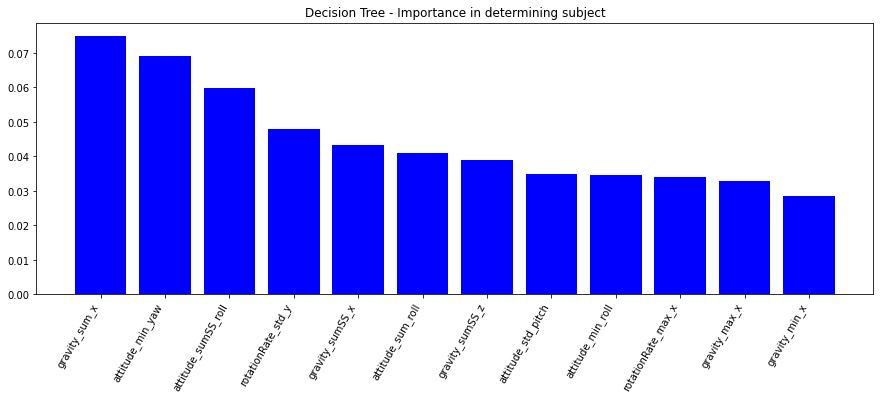

In [ ]:
#@title
feature_names = X.columns
X_names = feature_names


# for tree-based classifier's feature importance plotting
def plot_keyFeat_trees(classifier, feature_names, clf_id, top_features=10):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices_vis = indices[:top_features]
    
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    plt.bar(range(top_features), importances[indices_vis],
       color="b", align="center")
    plt.xticks(range(top_features), indices)
    plt.xlim([-1, top_features])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[indices_vis], rotation=60, ha='right')
    plt.show()

print('Decision tree accuracy:',accuracy_score(b_test, DT.predict(X_test)))
plot_keyFeat_trees(DT, X_names, 'Decision Tree - Importance in determining subject', top_features=12)

Random Forest accuracy: 0.9368800721370604


<Figure size 432x288 with 0 Axes>

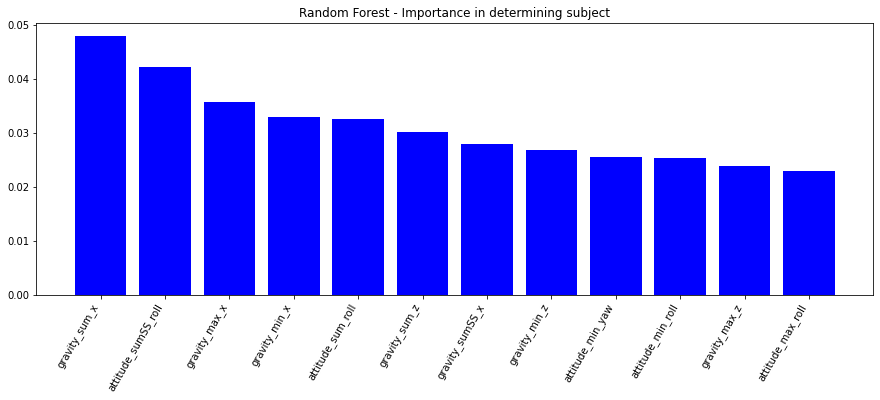

In [ ]:
#@title
print('Random Forest accuracy:',accuracy_score(b_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - Importance in determining subject', top_features=12)

Reset X and Y from Calculate Features
X = Df_Features.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Y = Df_Features['Activity']

In [ ]:
# Split our data
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y,
                                                    test_size=0.33,
                                                    random_state=42)

In [ ]:
LR_L1 = LogisticRegression(C=10, penalty='l2').fit(X_train, y_train)
LR_L2 = LogisticRegression(C=100, penalty='l2').fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
SVM_linear = SVC(kernel="linear", C=0.001).fit(X_train, y_train)
SVM_rbf = SVC(kernel="rbf", C=1000, gamma=1e-5).fit(X_train, y_train)

In [ ]:
DT = DecisionTreeClassifier(criterion='entropy').fit(X_train, y_train)
RF = RandomForestClassifier(criterion='entropy',n_estimators=1000).fit(X_train, y_train)

In [ ]:
print('linearSVM accuracy:',accuracy_score(y_test, SVM_linear.predict(X_test)))
print('rbf_SVM accuracy:',accuracy_score(y_test, SVM_rbf.predict(X_test)))
print('logistic_regression (L1) accuracy:',accuracy_score(y_test, LR_L1.predict(X_test)))
print('logistic_regression (L2) accuracy:',accuracy_score(y_test, LR_L2.predict(X_test)))
print('decision tree accuracy:',accuracy_score(y_test, DT.predict(X_test)))
print('Random Forest accuracy:',accuracy_score(y_test, RF.predict(X_test)))

linearSVM accuracy: 0.8178539224526601
rbf_SVM accuracy: 0.9747520288548241
logistic_regression (L1) accuracy: 0.9693417493237151
logistic_regression (L2) accuracy: 0.9675383228133454
decision tree accuracy: 0.9774571686203787
Random Forest accuracy: 0.9900811541929666


Confusion matrix, without normalization


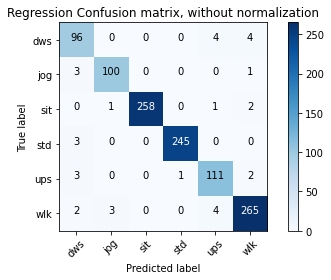

In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, LR_L1.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='Regression Confusion matrix, without normalization')

Confusion matrix, without normalization


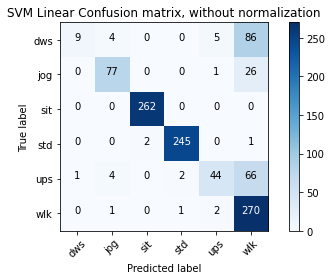

In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, SVM_linear.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='SVM Linear Confusion matrix, without normalization')

Confusion matrix, without normalization


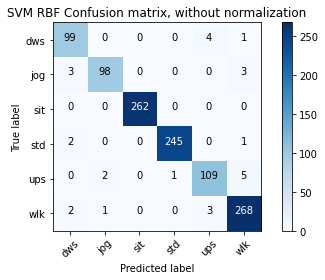

In [ ]:
#@title
### Confusion matrix (predictive performance on different classes)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    function provided by sklearn example
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

   # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cnf_matrix = confusion_matrix(y_test, SVM_rbf.predict(X_test))
plot_confusion_matrix(cnf_matrix, classes=activity_types,
                      title='SVM RBF Confusion matrix, without normalization')

In [ ]:
# this code is based on Bakharia'blog "Visualising Top Features in Linear SVM with Scikit Learn and Matplotlib"
# https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, clf_id, top_features=10):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 # create plot
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    

Decision tree accuracy: 0.9774571686203787


<Figure size 432x288 with 0 Axes>

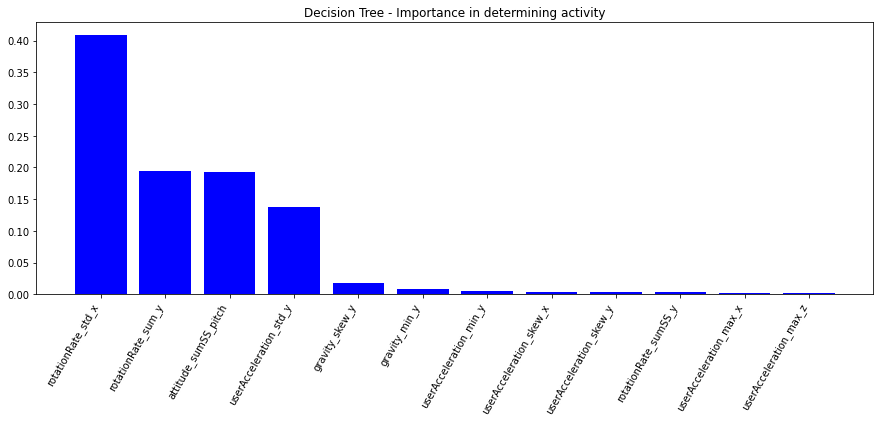

In [ ]:
#@title
feature_names = X.columns
X_names = feature_names


# for tree-based classifier's feature importance plotting
def plot_keyFeat_trees(classifier, feature_names, clf_id, top_features=10):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    indices_vis = indices[:top_features]
    
    plt.figure()
    plt.figure(figsize=(15, 5))
    plt.title(clf_id)
    plt.bar(range(top_features), importances[indices_vis],
       color="b", align="center")
    plt.xticks(range(top_features), indices)
    plt.xlim([-1, top_features])
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, top_features), feature_names[indices_vis], rotation=60, ha='right')
    plt.show()

print('Decision tree accuracy:',accuracy_score(y_test, DT.predict(X_test)))
plot_keyFeat_trees(DT, X_names, 'Decision Tree - Importance in determining activity', top_features=12)

Random Forest accuracy: 0.9900811541929666


<Figure size 432x288 with 0 Axes>

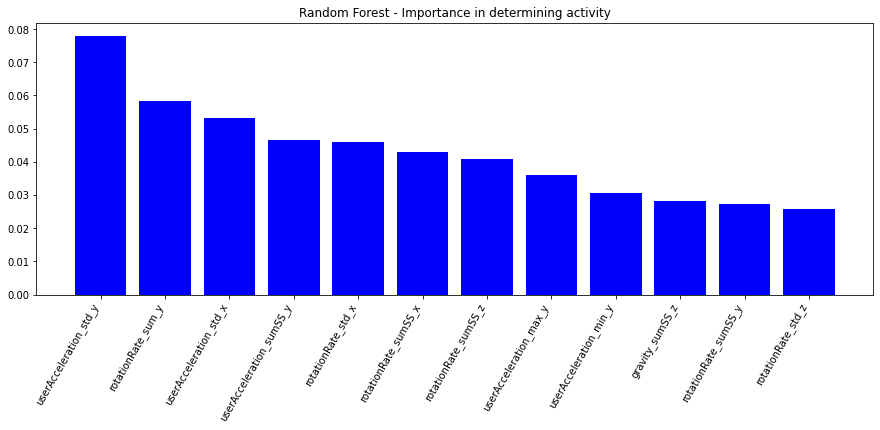

In [ ]:
#@title
print('Random Forest accuracy:',accuracy_score(y_test, RF.predict(X_test)))
plot_keyFeat_trees(RF, X_names, 'Random Forest - Importance in determining activity', top_features=12)

In [ ]:
Jog = Df_all.loc[(Df_all['Activity'] >= 2)
                     & (Df_all['Activity'] < 3)]

In [ ]:
Jog.tail(5)

,Unnamed: 0,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,Activity,Sub_Num,Exp_num
2838,2838,-1.017175,-1.162354,-1.310722,-0.337852,0.917741,-0.208826,-2.999562,-4.098313,-4.736243,-0.895730,1.181624,-0.150626,2,24,0.0
2839,2839,-1.292318,-1.078857,-1.562349,-0.454140,0.881418,-0.129842,-3.015364,0.439013,-6.663899,-2.954521,4.183477,0.853444,2,24,0.0
2840,2840,-1.403760,-0.951444,-1.709745,-0.572428,0.814255,-0.096516,-2.786093,-0.210998,-6.814220,-1.778753,3.831970,-0.317043,2,24,0.0
2841,2841,-1.504000,-0.843886,-1.828078,-0.663082,0.747231,-0.044358,-2.645476,-0.743427,-5.391820,-0.212925,1.475883,-0.199691,2,24,0.0
2842,2842,-1.550190,-0.746814,-1.889135,-0.733701,0.679304,-0.015121,-1.850569,1.000916,-4.605496,0.279294,1.813952,-0.002412,2,24,0.0


In [ ]:
print(f'The dimensions of the complete dataset are {Jog.shape}.')

The dimensions of the complete dataset are (134231, 16).


In [ ]:
print(f'The dimensions of the complete dataset are {Df_all.shape}.')

The dimensions of the complete dataset are (1412865, 16).


In [ ]:
ReducedJog = Jog[["attitude.roll", "attitude.pitch","attitude.yaw","gravity.x", "gravity.y","gravity.z","rotationRate.x","rotationRate.y", "rotationRate.z", "userAcceleration.x","userAcceleration.y","userAcceleration.z"]]

In [ ]:
print(f'The dimensions of the complete dataset are {ReducedJog.shape}.')

The dimensions of the complete dataset are (134231, 12).


In [ ]:
ReducedJog.head(5)

,attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z
0,-2.671148,-1.352146,-0.302768,-0.098321,0.976191,0.193345,-4.478135,-0.984990,-3.977462,-0.068427,2.444265,0.873351
1,-2.556245,-1.231228,-0.171759,-0.184022,0.942898,0.277627,-4.032277,-0.075990,-4.709382,-0.071548,5.795673,0.886497
2,-2.476689,-1.104242,-0.101438,-0.277524,0.893123,0.353989,-4.480188,0.991382,-5.111257,0.596921,2.000706,0.589691
3,-2.426052,-0.978654,-0.035098,-0.366153,0.829747,0.421248,-3.542794,-2.173665,-5.096380,-0.012723,1.050853,-0.453460
4,-2.512987,-0.858650,-0.002219,-0.384244,0.756961,0.528548,-4.274719,-7.624958,-4.127767,-0.540072,0.483197,-1.084990


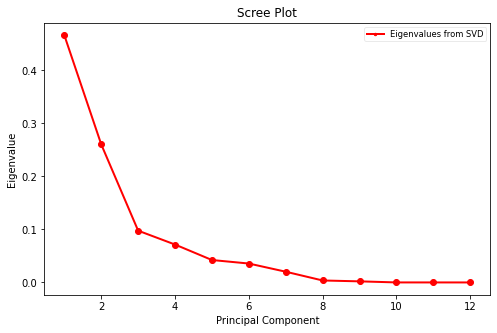

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

A = np.asmatrix(ReducedJog.T) * np.asmatrix(ReducedJog)
U, S, V = np.linalg.svd(A) 
eigvals = S**2 / np.sum(S**2)  # NOTE (@amoeba): These are not PCA eigenvalues. 
                               # This question is about SVD.

fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(12) + 1
plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
leg = plt.legend(['Eigenvalues from SVD'], loc='best', borderpad=0.3, 
                 shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                 markerscale=0.4)
leg.get_frame().set_alpha(0.4)
#leg.draggable(state=True)
plt.show()